In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 28333 
    Total predicted counts          : 28129.36
    Total off counts                : 100929.00

    Total background counts         : 20185.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.69 s, sys: 24.3 ms, total: 3.72 s
Wall time: 3.72 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 28089 
    Total predicted counts          : 28333.76
    Total off counts                : 101951.00

    Total background counts         : 20390.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 27989 
    Total predicted counts          : 28399.36
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 28110 
    Total predicted counts          : 28222.36
    Total off counts                : 101394.00

    Total background counts         : 20278.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 28283 
    Total predicted counts          : 28232.16
    Total off counts                : 101443.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 28399 
    Total predicted counts          : 28142.16
    Total off counts                : 100993.00

    Total background counts         : 20198.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_45 

    Total counts                    : 28043 
    Total predicted counts          : 28203.96
    Total off counts                : 101302.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 28169 
    Total predicted counts          : 28338.16
    Total off counts                : 101973.00

    Total background counts         : 20394.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 28016 
    Total predicted counts          : 28250.96
    Total off counts                : 101537.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_79 

    Total counts                    : 28201 
    Total predicted counts          : 28329.76
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_80 

    Total counts                    : 28123 
    Total predicted counts          : 28294.16
    Total off counts                : 101753.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_99 

    Total counts                    : 28119 
    Total predicted counts          : 28254.76
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_100 

    Total counts                    : 28445 
    Total predicted counts          : 28236.96
    Total off counts                : 101467.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_119 

    Total counts                    : 28233 
    Total predicted counts          : 28195.96
    Total off counts                : 101262.00

    Total background counts         : 20252.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_120 

    Total counts                    : 28219 
    Total predicted counts          : 28224.16
    Total off counts                : 101403.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_139 

    Total counts                    : 28175 
    Total predicted counts          : 28349.56
    Total off counts                : 102030.00

    Total background counts         : 20406.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_140 

    Total counts                    : 28263 
    Total predicted counts          : 28231.76
    Total off counts                : 101441.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_156 

    Total counts                    : 27976 
    Total predicted counts          : 28362.76
    Total off counts                : 102096.00

    Total background counts         : 20419.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_157 

    Total counts                    : 27952 
    Total predicted counts          : 28163.96
    Total off counts                : 101102.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_175 

    Total counts                    : 28477 
    Total predicted counts          : 28337.96
    Total off counts                : 101972.00

    Total background counts         : 20394.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_176 

    Total counts                    : 28416 
    Total predicted counts          : 28224.16
    Total off counts                : 101403.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 28270 
    Total predicted counts          : 28273.16
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 28190 
    Total predicted counts          : 28179.16
    Total off counts                : 101178.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_211 

    Total counts                    : 28609 
    Total predicted counts          : 28273.96
    Total off counts                : 101652.00

    Total background counts         : 20330.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_212 

    Total counts                    : 28083 
    Total predicted counts          : 28369.36
    Total off counts                : 102129.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 27957 
    Total predicted counts          : 28179.36
    Total off counts                : 101179.00

    Total background counts         : 20235.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 28293 
    Total predicted counts          : 28247.56
    Total off counts                : 101520.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 28397 
    Total predicted counts          : 28215.36
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_247 

    Total counts                    : 28289 
    Total predicted counts          : 28253.56
    Total off counts                : 101550.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_262 

    Total counts                    : 28661 
    Total predicted counts          : 28263.16
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 28470 
    Total predicted counts          : 28332.56
    Total off counts                : 101945.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 28204 
    Total predicted counts          : 28315.56
    Total off counts                : 101860.00

    Total background counts         : 20372.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 28200 
    Total predicted counts          : 28199.36
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_305 

    Total counts                    : 28369 
    Total predicted counts          : 28227.16
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 28059 
    Total predicted counts          : 28231.96
    Total off counts                : 101442.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_326 

    Total counts                    : 28182 
    Total predicted counts          : 28284.76
    Total off counts                : 101706.00

    Total background counts         : 20341.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_327 

    Total counts                    : 28171 
    Total predicted counts          : 28165.16
    Total off counts                : 101108.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_346 

    Total counts                    : 28285 
    Total predicted counts          : 28245.56
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_347 

    Total counts                    : 28125 
    Total predicted counts          : 28178.36
    Total off counts                : 101174.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 27760 
    Total predicted counts          : 28216.16
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 28323 
    Total predicted counts          : 28054.16
    Total off counts                : 100553.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_398 

    Total counts                    : 28229 
    Total predicted counts          : 28315.76
    Total off counts                : 101861.00

    Total background counts         : 20372.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 28039 
    Total predicted counts          : 28301.76
    Total off counts                : 101791.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 28187 
    Total predicted counts          : 28310.76
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 28154 
    Total predicted counts          : 28210.16
    Total off counts                : 101333.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_449 

    Total counts                    : 28342 
    Total predicted counts          : 28238.16
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 28397 
    Total predicted counts          : 28285.96
    Total off counts                : 101712.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_473 

    Total counts                    : 28156 
    Total predicted counts          : 28219.16
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 28132 
    Total predicted counts          : 28318.36
    Total off counts                : 101874.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_503 

    Total counts                    : 28339 
    Total predicted counts          : 28272.16
    Total off counts                : 101643.00

    Total background counts         : 20328.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_504 

    Total counts                    : 28170 
    Total predicted counts          : 28336.36
    Total off counts                : 101964.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 28228 
    Total predicted counts          : 28236.56
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_536 

    Total counts                    : 28575 
    Total predicted counts          : 28176.36
    Total off counts                : 101164.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 28454 
    Total predicted counts          : 28402.36
    Total off counts                : 102294.00

    Total background counts         : 20458.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_560 

    Total counts                    : 28262 
    Total predicted counts          : 28229.96
    Total off counts                : 101432.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_579 

    Total counts                    : 28169 
    Total predicted counts          : 28209.36
    Total off counts                : 101329.00

    Total background counts         : 20265.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_580 

    Total counts                    : 28162 
    Total predicted counts          : 28357.16
    Total off counts                : 102068.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_608 

    Total counts                    : 28429 
    Total predicted counts          : 28277.16
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_609 

    Total counts                    : 28238 
    Total predicted counts          : 28231.56
    Total off counts                : 101440.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_641 

    Total counts                    : 28115 
    Total predicted counts          : 28139.96
    Total off counts                : 100982.00

    Total background counts         : 20196.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_642 

    Total counts                    : 27967 
    Total predicted counts          : 28308.16
    Total off counts                : 101823.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_671 

    Total counts                    : 28222 
    Total predicted counts          : 28357.36
    Total off counts                : 102069.00

    Total background counts         : 20413.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_672 

    Total counts                    : 28258 
    Total predicted counts          : 28320.76
    Total off counts                : 101886.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_701 

    Total counts                    : 28518 
    Total predicted counts          : 28172.16
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_702 

    Total counts                    : 28128 
    Total predicted counts          : 28165.76
    Total off counts                : 101111.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_731 

    Total counts                    : 28393 
    Total predicted counts          : 28360.16
    Total off counts                : 102083.00

    Total background counts         : 20416.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_732 

    Total counts                    : 28463 
    Total predicted counts          : 28150.16
    Total off counts                : 101033.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 28316 
    Total predicted counts          : 28214.96
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 28217 
    Total predicted counts          : 28319.16
    Total off counts                : 101878.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_784 

    Total counts                    : 28420 
    Total predicted counts          : 28247.76
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_785 

    Total counts                    : 27940 
    Total predicted counts          : 28169.36
    Total off counts                : 101129.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_816 

    Total counts                    : 28024 
    Total predicted counts          : 28229.36
    Total off counts                : 101429.00

    Total background counts         : 20285.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_817 

    Total counts                    : 28283 
    Total predicted counts          : 28244.36
    Total off counts                : 101504.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_844 

    Total counts                    : 28380 
    Total predicted counts          : 28178.16
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 28333 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_870 

    Total counts                    : 27984 
    Total predicted counts          : 28331.36
    Total off counts                : 101939.00

    Total background counts         : 20387.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_871 

    Total counts                    : 28417 
    Total predicted counts          : 28315.36
    Total off counts                : 101859.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_901 

    Total counts                    : 28290 
    Total predicted counts          : 28201.56
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_902 

    Total counts                    : 28315 
    Total predicted counts          : 28295.96
    Total off counts                : 101762.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_923 

    Total counts                    : 28140 
    Total predicted counts          : 28223.56
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_924 

    Total counts                    : 28057 
    Total predicted counts          : 28168.96
    Total off counts                : 101127.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_956 

    Total counts                    : 28092 
    Total predicted counts          : 28211.76
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_957 

    Total counts                    : 28491 
    Total predicted counts          : 28251.36
    Total off counts                : 101539.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_989 

    Total counts                    : 28317 
    Total predicted counts          : 28266.56
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_990 

    Total counts                    : 28122 
    Total predicted counts          : 28241.16
    Total off counts                : 101488.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

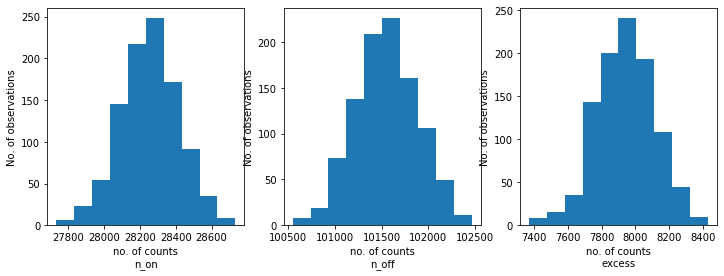

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 6min 15s, sys: 1.96 s, total: 6min 17s
Wall time: 7min 5s


In [15]:
results

[{'index': 2.08918040012255,
  'amplitude': 1.850177104819134e-12,
  'lambda_': 3.673352294360042},
 {'index': 2.246807419011836,
  'amplitude': 1.1098591702415119e-12,
  'lambda_': 2.7334017535608637},
 {'index': 2.106780651085318,
  'amplitude': 1.8190278475372278e-12,
  'lambda_': 3.589715644696545},
 {'index': 2.18563790614877,
  'amplitude': 1.4182434701104837e-12,
  'lambda_': 3.2199238719446983},
 {'index': 2.2335082148813235,
  'amplitude': 1.3108606151084685e-12,
  'lambda_': 3.0577825796166618},
 {'index': 2.2509457037855745,
  'amplitude': 1.1846104974806104e-12,
  'lambda_': 2.89042551828439},
 {'index': 2.3602379548752186,
  'amplitude': 8.955689341049595e-13,
  'lambda_': 2.5390207352432648},
 {'index': 2.0765373734656976,
  'amplitude': 1.9857797497104225e-12,
  'lambda_': 3.76726993622788},
 {'index': 2.2878256000698376,
  'amplitude': 1.0410776552645376e-12,
  'lambda_': 2.7678322508808515},
 {'index': 2.283895763951333,
  'amplitude': 1.0408090689897587e-12,
  'lambda

index: 2.215609406359966 += 0.08029782087225645


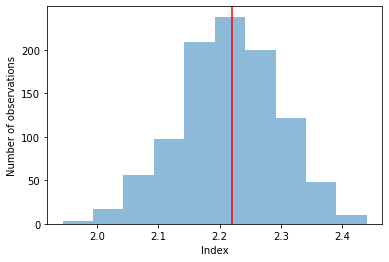

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3415187857487908e-12 += 3.222787493437153e-13


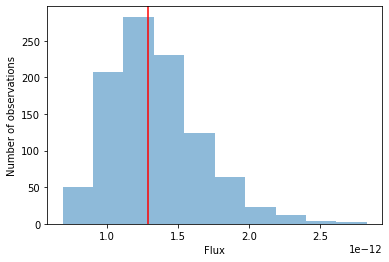

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 3.025322174435467 += 0.41379045779060986


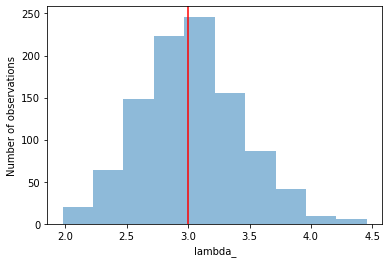

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")